In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy
import subprocess
%matplotlib inline

# 20181115-1冷却実験解析

In [2]:
import opmap
from opmap.rawCam import RawCam
from opmap.vmemMap import VmemMap
from opmap.apdMap import APDMap
from opmap.phaseMapHilbert import PhaseMapHilbert as PhaseMap
from opmap.phaseVarianceMap import PhaseVarianceMap

In [3]:
def FFT(vmem_1d, N, dt, fc_low=None, fc_high=None):
    fq = np.linspace(0, 1.0/dt, N)
    F = np.fft.fft(vmem_1d)
    if fc_low is not None:
        F[(fq <= fc_low)] = 0
    if fc_high is not None:
        F[(fq >= fc_high)] = 0
    
    F_abs = np.abs(F)
    F_abs_amp = F_abs/N
#     F_abs_amp[0] = F_abs_amp[0]/2
    F_abs_amp[0] = 0
    
    F_ifft = np.fft.ifft(F)
    F_ifft_real = F_ifft.real * 2
    
    return F_ifft_real

In [4]:
def isochronal(pmap, threshold):
    contour = np.zeros_like(pmap.data)

    for i in range(contour.shape[1]):
        for j in range(contour.shape[2]):        
            if pmap.roi[i,j] == 1:
                counter = 0
                for time in range(contour.shape[0]):
                    if time == 0:
                        pass
                    elif ((pmap.data[time-1, i, j] < threshold) * (pmap.data[time, i, j] > threshold)) == 1:
                        counter = 0

                    contour[time, i, j] = counter
                    counter += 1
                
    return contour

## 解像度を上げた影響評価

#### 128 x 128 20181106-1/C001H001S0010 (冷却なし)

In [86]:
data_path = '/mnt/Jalife/ExperimentData/20181106-1/C001H001S0010/'
start = 300
end = 900
date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/', '%s/%s/%s-%s' % (date, session_name, start, end))

In [87]:
raw1 = RawCam(path=data_path, cam_type='sa4',
              image_width=128, image_height=128, frame_start=start, frame_end=end)
raw1.setIntROI(400)
raw1.setRectROI(left=30)
# raw.morphROI(closing=10)
# raw.morphROI(erosion=3)

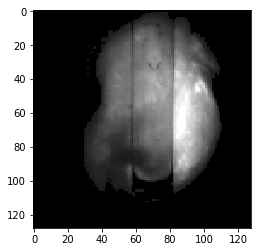

In [222]:
raw1.showFrame(0)

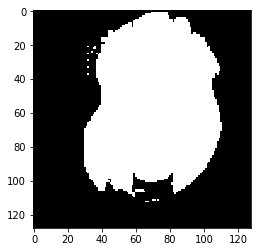

In [223]:
raw1.showROI()

In [58]:
if not os.path.exists(os.path.join(save_parent, 'raw')):
    os.makedirs(os.path.join(save_parent, 'raw'))

raw1.saveImage(os.path.join(save_parent, 'raw'), img_type='png', skip=1)
cmd = 'ffmpeg -r 30 -y -i "{0}/raw/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/raw_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

In [123]:
vmem1 = VmemMap(raw1)
vmem1.setDiffRange(diff_min=20)
vmem1.morphROI(closing=4)
vmem1.morphROI(erosion=8)

vmem1.smooth(size=5)

for i in range(vmem1.data.shape[1]):
    for j in range(vmem1.data.shape[2]):
        vmem1.data[:, i, j] = FFT(vmem1.data[:, i, j], vmem1.data.shape[0], 0.002, fc_low=0, fc_high=50)
        im_range = (np.max(vmem1.data[:, i, j]) - np.min(vmem1.data[:, i, j])) + (np.max(vmem1.data[:, i, j]) == np.min(vmem1.data[:, i, j])) * 1
        vmem1.data[:, i, j] = 2.0 * (vmem1.data[:, i, j] - np.min(vmem1.data[:, i, j])) / im_range - 1.0

vmem1.data = vmem1.data * vmem1.roi

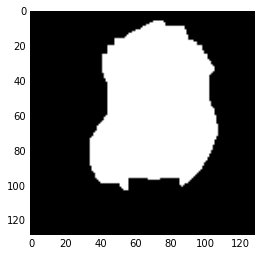

In [124]:
vmem1.showROI()

In [225]:
if not os.path.exists(os.path.join(save_parent, 'vmem')):
    os.makedirs(os.path.join(save_parent, 'vmem'))

vmem1.saveImage(os.path.join(save_parent, 'vmem'), img_type='png', skip=1)
cmd = 'ffmpeg -r 30 -y -i "{0}/vmem/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/vmem_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

In [172]:
pmap = PhaseMap(vmem1, shrink=1)

if not os.path.exists(os.path.join(save_parent, 'pmap')):
    os.makedirs(os.path.join(save_parent, 'pmap'))

# pmap.saveImage(os.path.join(save_parent, 'pmap'), img_type='png', skip=1)
# cmd = 'ffmpeg -r 30 -y -i "{0}/pmap/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/pmap_movie.mp4"'.format(save_parent)
# subprocess.call(cmd, shell=True)

In [173]:
contour = isochronal(pmap, -1.6)

In [219]:
nx = 128
ny = 128

xx = np.linspace(0,nx,nx)
yy = np.linspace(0,ny,ny)
labels = np.linspace(0, 100, 101)

xx,yy = np.meshgrid(xx,yy)

zz = contour[600, ::-1, :]*2

plt.figure(figsize=(4, 4))
plt.contour(xx, yy, zz, labels, cmap='jet')

plt.xticks([])
plt.yticks([])

# plt.colorbar()
# cont.clabel(fmt='%1.0f', fontsize=8)

plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/C001H001S0010/0--1/isochronal_600.png', dpi=600)
plt.close()

In [125]:
APD = APDMap(vmem1, max_beats=3, thre_up=0.6, thre_down=0.1, sigma_t=5)

In [136]:
data = APD.data[1, :, :]*(APD.data[1, :, :] < 110)
plt.imshow(data*2, vmin=150, vmax=np.max(data*2))

plt.xticks([])
plt.yticks([])

plt.colorbar()

plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/C001H001S0010/0--1/APD_600.png', dpi=600)
plt.close()

#### 256 x 256 20181115-1/C001H001S0001 (冷却なし)

In [100]:
data_path = '/mnt/Jalife/ExperimentData/20181115-1/C001H001S0001/'
start = 0
end = 500
date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/', '%s/%s/%s-%s' % (date, session_name, start, end))

In [101]:
raw2 = RawCam(path=data_path, cam_type='sa4',
              image_width=256, image_height=256, frame_start=start, frame_end=end)
raw2.setIntROI(50)
# raw2.setRectROI(left=30)
# raw.morphROI(closing=10)
# raw.morphROI(erosion=3)

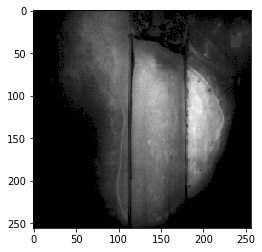

In [102]:
raw2.showFrame(0)

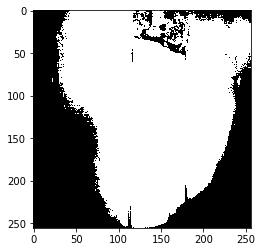

In [103]:
raw2.showROI()

In [93]:
if not os.path.exists(os.path.join(save_parent, 'raw')):
    os.makedirs(os.path.join(save_parent, 'raw'))

raw2.saveImage(os.path.join(save_parent, 'raw'), img_type='png', skip=1)
cmd = 'ffmpeg -r 30 -y -i "{0}/raw/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/raw_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

In [104]:
vmem2 = VmemMap(raw2)
vmem2.setDiffRange(diff_min=20)
# vmem2.morphROI(closing=3)
# vmem2.morphROI(erosion=3)

vmem2.smooth(size=9)

for i in range(vmem2.data.shape[1]):
    for j in range(vmem2.data.shape[2]):
        vmem2.data[:, i, j] = FFT(vmem2.data[:, i, j], vmem2.data.shape[0], 0.002, fc_low=0, fc_high=50)
        im_range = (np.max(vmem2.data[:, i, j]) - np.min(vmem2.data[:, i, j])) + (np.max(vmem2.data[:, i, j]) == np.min(vmem2.data[:, i, j])) * 1
        vmem2.data[:, i, j] = 2.0 * (vmem2.data[:, i, j] - np.min(vmem2.data[:, i, j])) / im_range - 1.0

vmem2.data = vmem2.data * vmem2.roi

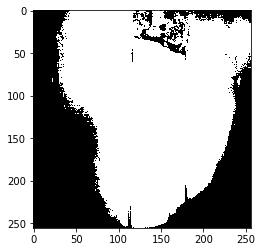

In [105]:
vmem2.showROI()

In [106]:
if not os.path.exists(os.path.join(save_parent, 'vmem')):
    os.makedirs(os.path.join(save_parent, 'vmem'))

vmem2.saveImage(os.path.join(save_parent, 'vmem'), img_type='png', skip=1)
cmd = 'ffmpeg -r 30 -y -i "{0}/vmem/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/vmem_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

In [107]:
pmap = PhaseMap(vmem2, shrink=2)

if not os.path.exists(os.path.join(save_parent, 'pmap')):
    os.makedirs(os.path.join(save_parent, 'pmap'))

pmap.saveImage(os.path.join(save_parent, 'pmap'), img_type='png', skip=1)
cmd = 'ffmpeg -r 30 -y -i "{0}/pmap/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{0}/pmap_movie.mp4"'.format(save_parent)
subprocess.call(cmd, shell=True)

0

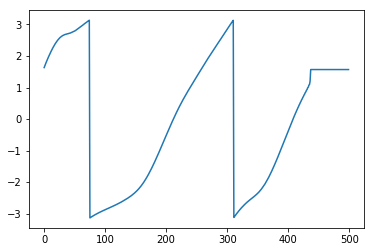

In [146]:
plt.plot(pmap.data[:, 60, 100])

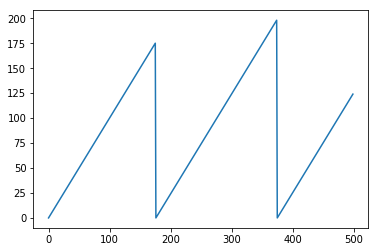

In [145]:
plt.plot(contour[:, 60, 100])

In [131]:
contour = np.zeros_like(pmap.data)

for i in range(contour.shape[1]):
    for j in range(contour.shape[2]):        

        counter = 0
        for time in range(contour.shape[0]):
            if time == 0:
                pass
            elif ((pmap.data[time-1, i, j] < -1.6) * (pmap.data[time, i, j] > -1.6)) == 1:
                counter = 0

            contour[time, i, j] = counter
            counter += 1

In [140]:
np.unique(contour[300, :, :])

array([ 29.,  31.,  32.,  33.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,
        42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,
        53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  65.,
        74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,
        85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  94., 100., 101.,
       102., 103., 104., 105., 106., 107., 108., 109., 110., 111., 112.,
       113., 114., 115., 116., 117., 118., 119., 120., 121., 122., 123.,
       124., 125., 126., 127., 128., 129., 130., 131., 132., 133., 134.,
       135., 136., 137., 138., 139., 140., 141., 142., 143., 144., 145.,
       146., 147., 148., 149., 150., 151., 152., 153., 154., 155., 156.,
       157., 158., 159., 160., 161., 162., 163., 164., 165., 166., 167.,
       168., 169., 170., 171., 172., 173., 174., 175., 176., 177., 178.,
       179., 180., 181., 182., 183., 184., 300.])

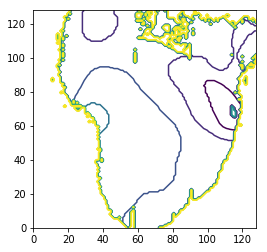

In [144]:
nx = 128
ny = 128

xx = np.linspace(0,nx,nx)
yy = np.linspace(0,ny,ny)

xx,yy = np.meshgrid(xx,yy)

zz = contour[200, ::-1, :]

plt.figure(figsize=(4, 4))
plt.contour(xx, yy, zz, [20, 40, 60, 80, 100, 120, 140, 160, 180, 200])

##### 膜電位比較

In [ ]:
plt.subplot(2,1,1)
plt.plot(vmem1.data[140:510, 64, 64])
plt.xlim([0, 370])
plt.ylim([-1 ,1])
plt.xticks([])
plt.yticks(size=14)
plt.title('128 x 128', size=16)

plt.subplot(2,1,2)
plt.plot(vmem2.data[110:480, 128, 128])
plt.xlim([0, 370])
plt.ylim([-1 ,1])
plt.xticks([0, 100, 200, 300], [0, 200, 400, 600], size=14)
plt.yticks(size=14)
plt.title('256 x 256', size=16)

plt.tight_layout()

plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181115-1/signal_noise.png', dpi=600)
plt.close()

# 20181106-1

## 特許用の画像作成

In [147]:
import pandas as pd

sample = pd.read_csv('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/ECG/sample.csv',
                     header=9, engine='python', encoding='us-ascii')
S0018 = pd.read_csv('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/ECG/S0018.csv',
                    header=9, engine='python', encoding='us-ascii')
S0019_1 = pd.read_csv('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/ECG/S0019_1.csv',
                    header=9, engine='python', encoding='us-ascii')
S0019_2 = pd.read_csv('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/ECG/S0019_2.csv',
                    header=9, engine='python', encoding='us-ascii')
S0020 = pd.read_csv('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/ECG/S0020.csv',
                    header=9, engine='python', encoding='us-ascii')
S0021 = pd.read_csv('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/ECG/S0021.csv',
                    header=9, engine='python', encoding='us-ascii')
S0022_1 = pd.read_csv('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/ECG/S0022_1.csv',
                    header=9, engine='python', encoding='us-ascii')
S0022_2 = pd.read_csv('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/ECG/S0022_2.csv',
                    header=9, engine='python', encoding='us-ascii')

In [250]:
S0018 = S0018[['mV.3']].values[:-1]
S0020 = S0020[['mV.3']].values[:-1]
S0021 = S0021[['mV.3']].values[:-1]

## S0018

In [334]:
plt.plot(S0018[10000:11000], linewidth=3)
plt.xticks([0, 200, 400, 600, 800, 1000], [0, 0.2, 0.4, 0.6, 0.8, 1.0], size=20)
plt.yticks(size=20)
plt.ylim([-0.25, 0.25])

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/C001H001S0018/ECG_before.png', dpi=600)
plt.close()

In [336]:
plt.plot(S0018[45500:46500], linewidth=3)
plt.xticks([0, 200, 400, 600, 800, 1000], [0, 0.2, 0.4, 0.6, 0.8, 1.0], size=20)
plt.yticks(size=20)
plt.ylim([-0.25, 0.25])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/C001H001S0018/ECG_start.png', dpi=600)
plt.close()

In [383]:
plt.plot(S0018[66100:67100], linewidth=3)
plt.xticks([0, 200, 400, 600, 800, 1000], [20.6, 20.8, 21.0, 21.2, 21.4, 21.6], size=20)
plt.yticks([])
plt.ylim([-0.25, 0.25])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/C001H001S0018/ECG_mid.png', dpi=600)
plt.close()

In [382]:
plt.plot(S0018[86900:87900], linewidth=3)
plt.xticks([0, 200, 400, 600, 800, 1000], [41.4, 41.6, 41.8, 42.0, 42.2, 42.4], size=20)
plt.ylim([-0.25, 0.25])
plt.yticks([])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/C001H001S0018/ECG_termination.png', dpi=600)
plt.close()

## S0020

In [381]:
plt.plot(S0020[2000:3000], linewidth=3)
plt.xticks([0, 200, 400, 600, 800, 1000], [0, 0.2, 0.4, 0.6, 0.8, 1.0], size=20)
plt.ylim([-0.25, 0.25])
plt.yticks(size=20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/C001H001S0020/ECG_before.png', dpi=600)
plt.close()

In [380]:
plt.plot(S0020[20000:21000], linewidth=3)
plt.xticks([0, 200, 400, 600, 800, 1000], [0, 0.2, 0.4, 0.6, 0.8, 1.0], size=20)
plt.ylim([-0.25, 0.25])
plt.yticks(size=20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/C001H001S0020/ECG_start.png', dpi=600)
plt.close()

In [379]:
plt.plot(S0020[30400:31400], linewidth=3)
plt.xticks([0, 200, 400, 600, 800, 1000], [10.4, 10.6, 10.8, 11.0, 11.2, 11.4], size=20)
plt.ylim([-0.25, 0.25])
plt.yticks([])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/C001H001S0020/ECG_mid.png', dpi=600)
plt.close()

In [378]:
plt.plot(S0020[41400:42400], linewidth=3)
plt.xticks([0, 200, 400, 600, 800, 1000], [21.4, 21.6, 21.8, 22.0, 22.2, 22.4], size=20)
plt.ylim([-0.25, 0.25])
plt.yticks([])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/C001H001S0020/ECG_termination.png', dpi=600)
plt.close()

## S0021

In [377]:
plt.plot(S0021[2000:3000], linewidth=3)
plt.xticks([0, 200, 400, 600, 800, 1000], [0, 0.2, 0.4, 0.6, 0.8, 1.0], size=20)
plt.ylim([-0.25, 0.25])
plt.yticks(size=20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/C001H001S0021/ECG_before.png', dpi=600)
plt.close()

In [376]:
plt.plot(S0021[15300:16300], linewidth=3)
plt.xticks([0, 200, 400, 600, 800, 1000], [0, 0.2, 0.4, 0.6, 0.8, 1.0], size=20)
plt.ylim([-0.25, 0.25])
plt.yticks(size=20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/C001H001S0021/ECG_start.png', dpi=600)
plt.close()

In [374]:
plt.plot(S0021[26700:27700], linewidth=3)
plt.xticks([0, 200, 400, 600, 800, 1000], [11.4, 11.6, 11.8, 12.0, 12.2, 12.4], size=20)
plt.ylim([-0.25, 0.25])
plt.yticks([])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/C001H001S0021/ECG_mid.png', dpi=600)
plt.close()

In [375]:
plt.plot(S0021[37900:38900], linewidth=3)
plt.xticks([0, 200, 400, 600, 800, 1000], [22.6, 22.8, 23.0, 23.2, 23.4, 23.6], size=20)
plt.ylim([-0.25, 0.25])
plt.yticks([])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/20181106-1/C001H001S0021/ECG_termination.png', dpi=600)
plt.close()

## S0019

## S0022

In [313]:
a = S0019_1[['mV.6']].values[:-1]
b = S0019_1[['mV.3']].values[:-1]
c = S0022_1[['mV.3']].values[:-1]

In [294]:
b.shape

(134487, 1)

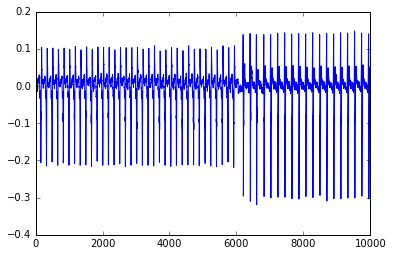

In [312]:
plt.plot(b[25000:35000])

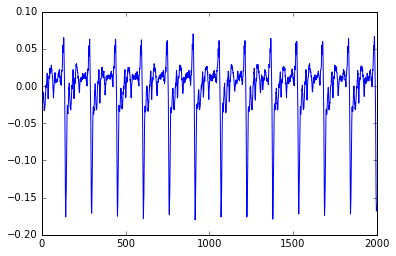

In [322]:
plt.plot(c[10000:12000])

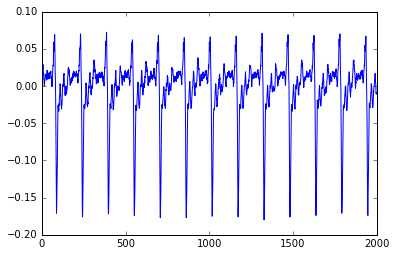

In [323]:
plt.plot(c[50000:52000])